# Define parameters

**Garmin Connect Health API** provide **heart rate**, **steps**, **stress score**, and **sleep** in different intervals.
* Heart rate: every 15 seconds
* Steps: every 15 minutes
* Stress score: every 3 minutes
* Sleep: every day

Resampling plan to transform to `target_freq`
* For 15sec
    * heart_rate: 15sec -> 15sec as-is
    * steps:      15min -> 15sec as-is
    * stress:     3min  -> 15sec downsample
    * sleep:      1day  -> 15sec upsample
* For 1min
    * heart_rate: 15sec -> 1min downsample
    * steps:      15min -> 1min upsample
    * stress:     3min  -> 1min upsample
    * sleep:      1day  -> 1min upsample
* For 15min
    * heart_rate: 15sec -> 15min downsample
    * steps:      15min -> 15min as-is
    * stress:     3min  -> 15min downsample
    * sleep:      1day  -> 15min upsample

In [2]:
target_freq_as_int = 15
target_freq_unit1 = 's' # min|s
target_freq_unit2 = 's' # m|s
target_freq = f'{target_freq_as_int}{target_freq_unit1}'
target_freq2 = f'{target_freq_as_int}{target_freq_unit2}'

In [3]:
user = 'participant2' # participant1|participant2
if user == 'participant1':
    user_id = 5
else:
    user_id = 6
start_date = '2021-02-23'
# end_date = '2021-03-23' 
end_date_plus_one = '2021-03-24' # 30-day inclusive
end_date_plus_two = '2021-03-25'
activity_type_id = 2 # wearing-off

color = {
    "boxes": "Blue",
    "whiskers": "Black",
    "medians": "Red",
    "caps": "Gray"
}

# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import seaborn
import math

# Import FonLog Dataset

## Process wearing-off dataset

In [5]:
# Load from file
# fonlog_data = pd.read_excel(
#     r"C:\Users\ftska\OneDrive\Desktop\Japan Internship'25\Macky\Parkison's\Victorina\Old_dataset\Garmin Paper 2021 Supplementary Materials\Garmin論文2021 補足資料\For Submission\PD_processed_fonlog_input_with_metadata.csv",
#     sheet_name='records',
#     engine='openpyxl'
# )

fonlog_data = pd.read_excel(
    r"C:\Users\ftska\OneDrive\Desktop\Japan Internship'25\Macky\Parkison's\Victorina\Old_dataset\Garmin Paper 2021 Supplementary Materials\Garmin論文2021 補足資料\For Submission\data\fonlog\records.xlsx",
    sheet_name='records',
    engine='openpyxl'
)

# Make sure to use datetime data type
fonlog_data['activity.started_at'] = pd.to_datetime(fonlog_data['activity.started_at'])
fonlog_data['activity.finished_at'] = pd.to_datetime(fonlog_data['activity.finished_at'])

# Filter Wearing-off Questionnaire, collection period
filtered_fonlog_data = fonlog_data.loc[
    (fonlog_data['activity_target.user_id'] == user_id) &
    (fonlog_data['activity_type_group.name'] == 'Wearing-off Questionnaire (WOQ)') &
    (fonlog_data['activity.started_at'] >= start_date) &
    (fonlog_data['activity.started_at'] < end_date_plus_two) &
    (fonlog_data['record_type.activity_type_id'] == activity_type_id)
]

grouped_fonlog_data = filtered_fonlog_data.groupby('activity_target.activity_id')

# Extract wearing-off periods
wearing_off_periods = grouped_fonlog_data[
    ['activity.started_at', 'activity.finished_at', 'activity_target.activity_id']
].agg('first').rename(
    columns={
        "activity.started_at": "started_at",
        "activity.finished_at": "finished_at",
        "activity_target.activity_id": "wearing_off_id"
    }
)

# Compute wearing-off duration
wearing_off_periods['Duration'] = (
    (wearing_off_periods['finished_at'] - wearing_off_periods['started_at']) / np.timedelta64(1, "s")
) / 60.  # in minutes

# Show wearing-off summary
display(wearing_off_periods['Duration'].describe())
display(wearing_off_periods.head())


count     44.000000
mean      25.295455
std       34.511595
min        0.000000
25%        0.000000
50%       17.500000
75%       40.000000
max      170.000000
Name: Duration, dtype: float64

,started_at,finished_at,wearing_off_id,Duration
activity_target.activity_id,,,,
143,2021-02-24 11:24:55,2021-02-24 11:24:55,143,0.0
205,2021-02-25 10:54:19,2021-02-25 10:54:19,205,0.0
274,2021-02-27 07:10:00,2021-02-27 07:50:00,274,40.0
283,2021-02-27 10:00:00,2021-02-27 10:40:00,283,40.0
286,2021-02-27 12:30:00,2021-02-27 12:30:00,286,0.0


Remove overarching reporting when there are embedded reportings.
For example, 

11:00 AM      **12:00 PM**        **12:30 PM**     1:00 PM  
    |-------------|----------------|-----------|
          

In [6]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select distinct
        wearing_off_2.[activity_target.activity_id] as for_remove_id
    from wearing_off_periods as wearing_off_1
    join wearing_off_periods as wearing_off_2
    on (wearing_off_2.[started_at] < wearing_off_1.[finished_at] AND wearing_off_2.[started_at] < wearing_off_1.[started_at]) AND
            (wearing_off_2.[finished_at] > wearing_off_1.[finished_at] AND wearing_off_2.[finished_at] > wearing_off_1.[started_at]) AND
            (wearing_off_1.[wearing_off_id] <> wearing_off_2.[wearing_off_id])
'''
for_remove_ids = pysqldf(cond_join)
wearing_off_periods = wearing_off_periods[
    ~wearing_off_periods['wearing_off_id'].isin(for_remove_ids['for_remove_id'])
]
display(wearing_off_periods['Duration'].describe())
display(wearing_off_periods.head())
display(wearing_off_periods.tail())

count     44.000000
mean      25.295455
std       34.511595
min        0.000000
25%        0.000000
50%       17.500000
75%       40.000000
max      170.000000
Name: Duration, dtype: float64

,started_at,finished_at,wearing_off_id,Duration
activity_target.activity_id,,,,
143,2021-02-24 11:24:55,2021-02-24 11:24:55,143,0.0
205,2021-02-25 10:54:19,2021-02-25 10:54:19,205,0.0
274,2021-02-27 07:10:00,2021-02-27 07:50:00,274,40.0
283,2021-02-27 10:00:00,2021-02-27 10:40:00,283,40.0
286,2021-02-27 12:30:00,2021-02-27 12:30:00,286,0.0


,started_at,finished_at,wearing_off_id,Duration
activity_target.activity_id,,,,
682,2021-03-17 08:40:00,2021-03-17 08:40:00,682,0.0
683,2021-03-17 12:35:00,2021-03-17 12:35:00,683,0.0
684,2021-03-17 14:13:25,2021-03-17 14:13:25,684,0.0
732,2021-03-20 07:12:00,2021-03-20 08:40:00,732,88.0
734,2021-03-20 08:40:00,2021-03-20 09:00:00,734,20.0


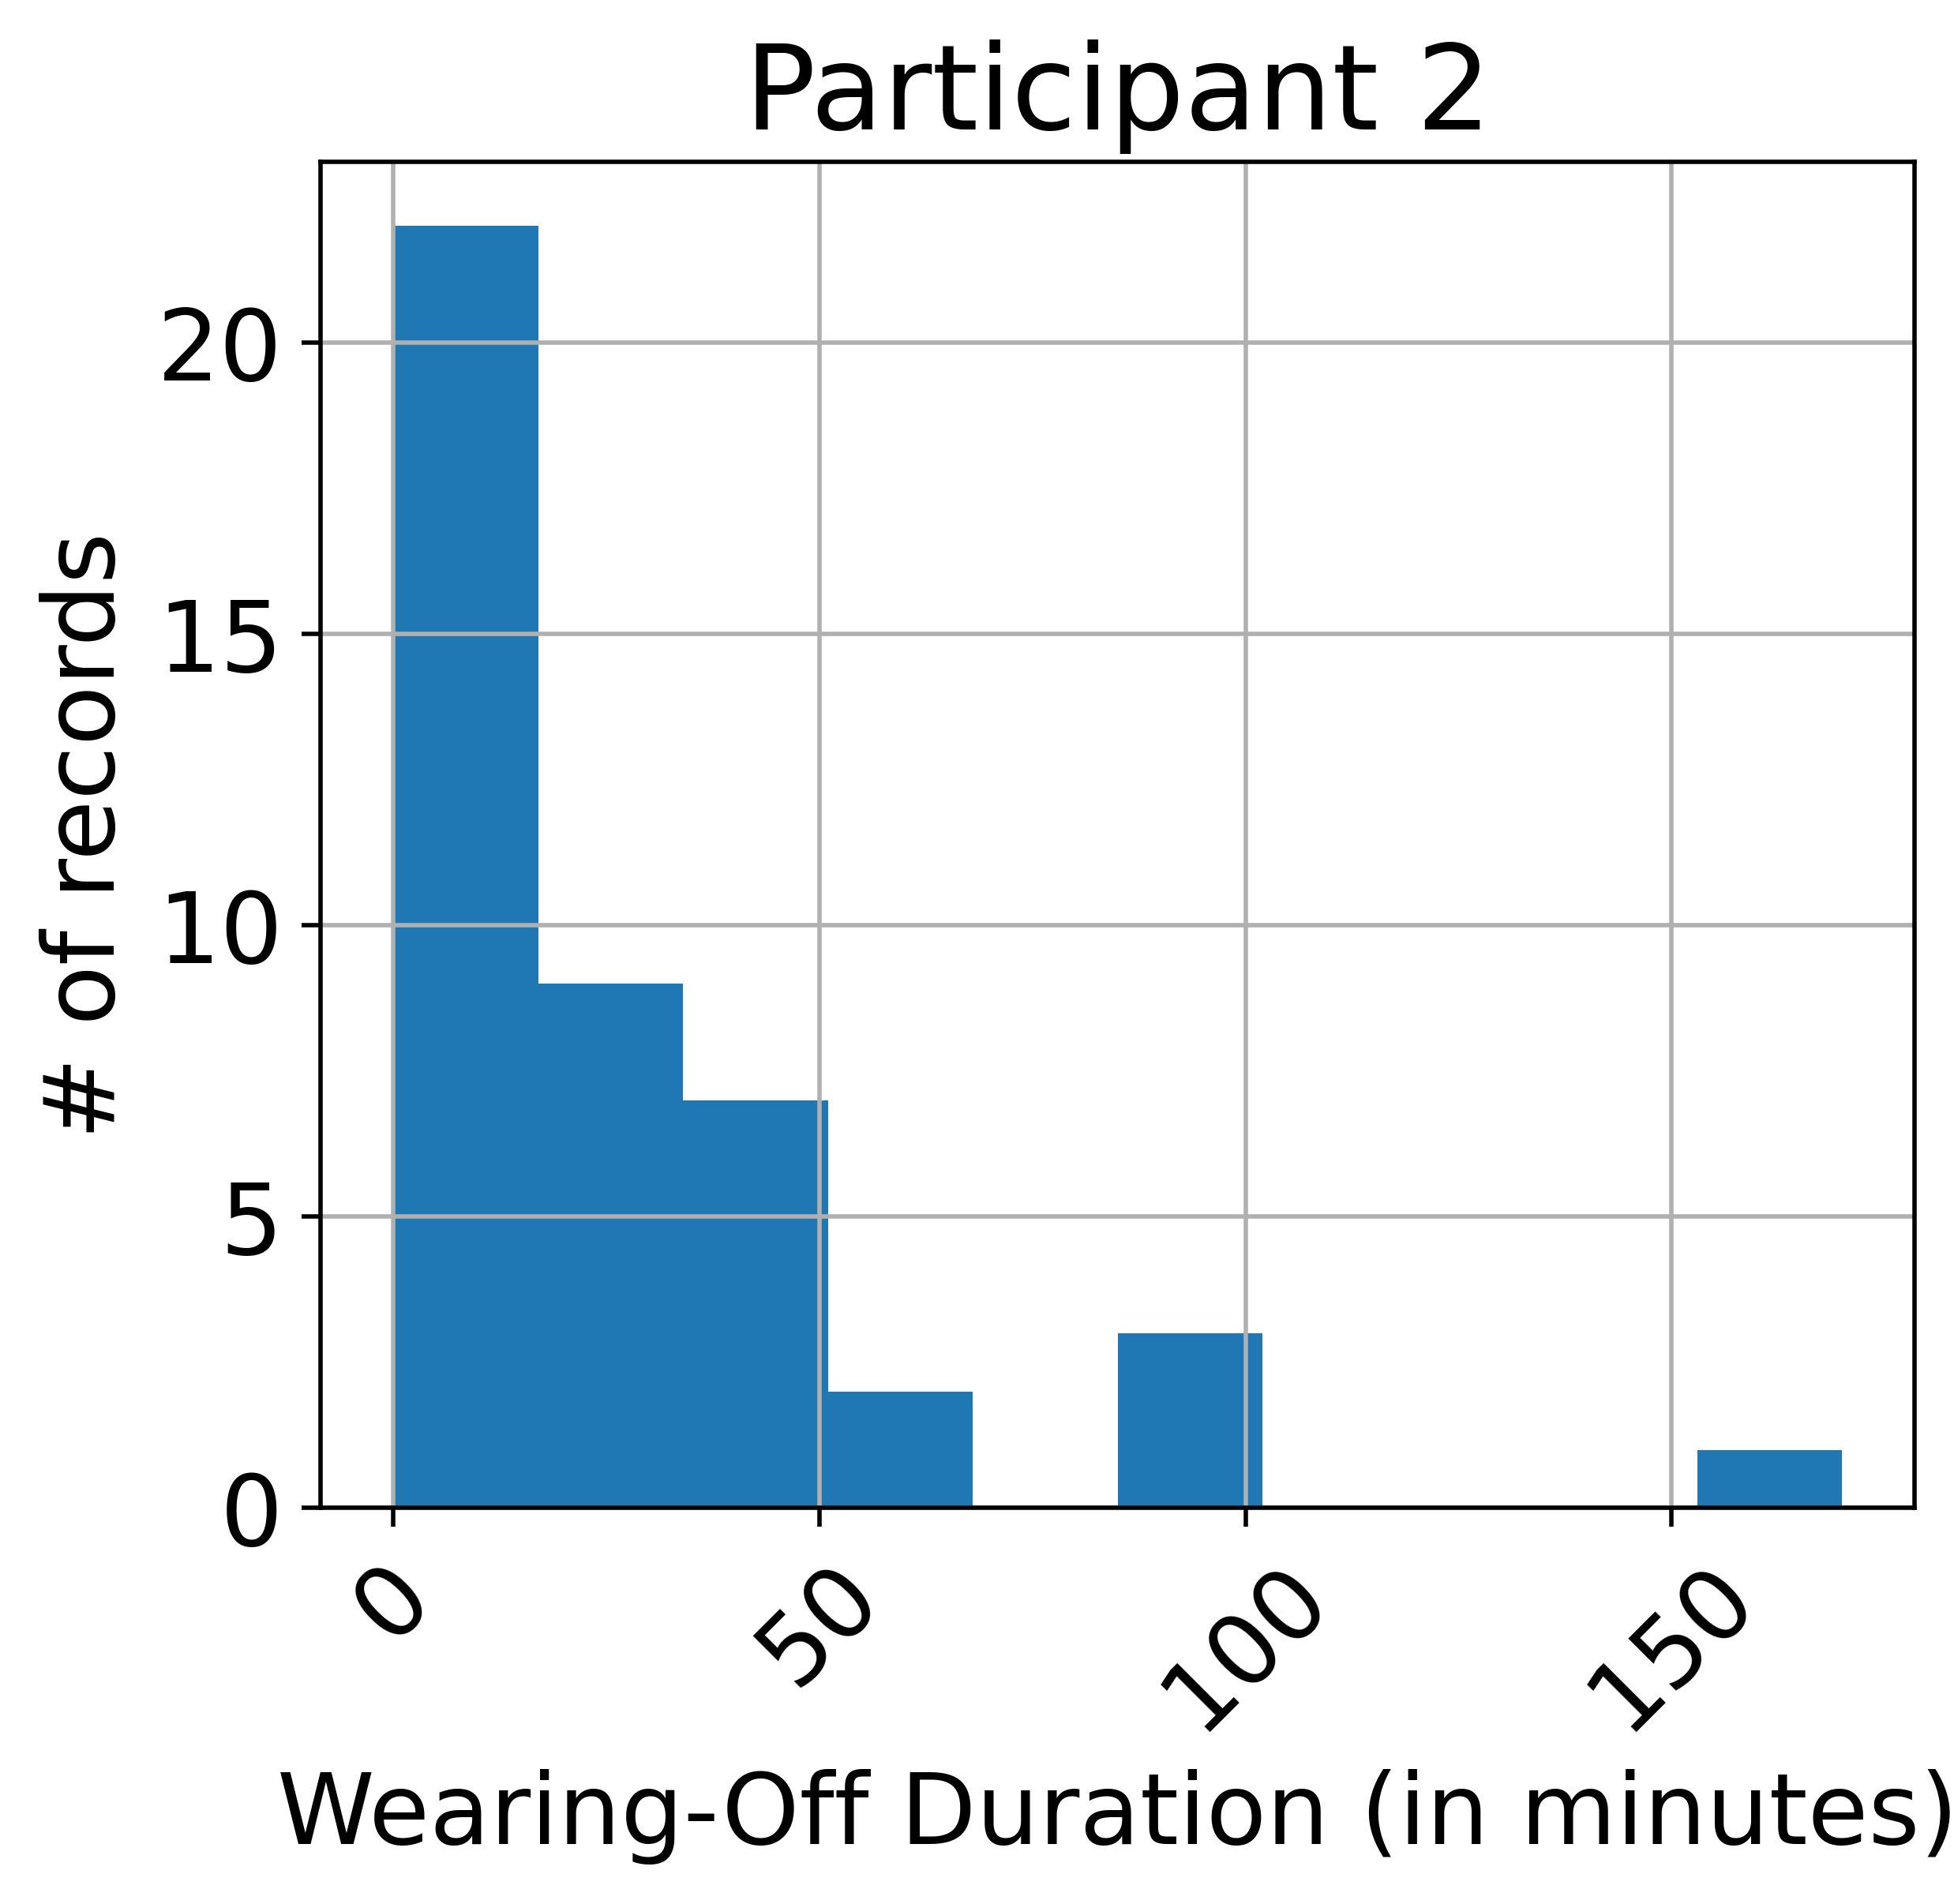

In [7]:
plt.rcParams['font.size'] = '18'
f = plt.figure(figsize=(5,5), dpi=500)
ax1 = wearing_off_periods['Duration'].hist(
    figsize = (5,5)
)
ax1.set_ylabel(r'# of records')
ax1.set_title('Participant 2')
ax1.set_xlabel(r'Wearing-Off Duration (in minutes)')
ax1.tick_params(axis='x',labelrotation=45)
plt.suptitle('')
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
f.tight_layout(pad=0.5)
# plt.savefig('./visualization/woq1.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Process drug intake dataset

In [8]:
# Apply aggregation on existing grouped data
drug_intake = grouped_fonlog_data[
    ['activity.started_at', 'activity.finished_at', 'record_type.activity_type_id']
].agg(lambda x: np.unique(x)[0]).rename(
    columns={
        "activity.started_at": "started_at",
        "activity.finished_at": "finished_at",
        "record_type.activity_type_id": "activity_type_id"
    }
)

# Reset index and rename appropriately if needed
drug_intake.reset_index(inplace=True)
drug_intake.rename(columns={'activity_target.activity_id': 'drug_intake_id'}, inplace=True)

# Show drug intake summary
display(drug_intake['drug_intake_id'].describe())
display(drug_intake.head())


count     44.000000
mean     407.295455
std      145.401702
min      143.000000
25%      304.500000
50%      366.500000
75%      431.000000
max      734.000000
Name: drug_intake_id, dtype: float64

,drug_intake_id,started_at,finished_at,activity_type_id
0,143,2021-02-24 11:24:55,2021-02-24 11:24:55,2
1,205,2021-02-25 10:54:19,2021-02-25 10:54:19,2
2,274,2021-02-27 07:10:00,2021-02-27 07:50:00,2
3,283,2021-02-27 10:00:00,2021-02-27 10:40:00,2
4,286,2021-02-27 12:30:00,2021-02-27 12:30:00,2


Remove overarching reporting when there are embedded reportings.

11:00 AM      **12:00 PM**        **12:30 PM**     1:00 PM  
    |-------------|----------------|-----------|
          

In [9]:
# SQL function
pysqldf = lambda q: sqldf(q, globals())

# Correct SQL query using consistent column names
cond_join = '''
    SELECT DISTINCT
        drug_intake_2.[drug_intake_id] AS for_remove_id
    FROM drug_intake AS drug_intake_1
    JOIN drug_intake AS drug_intake_2
    ON (drug_intake_2.[started_at] < drug_intake_1.[finished_at] AND 
        drug_intake_2.[started_at] < drug_intake_1.[started_at]) AND
       (drug_intake_2.[finished_at] > drug_intake_1.[finished_at] AND 
        drug_intake_2.[finished_at] > drug_intake_1.[started_at]) AND
       (drug_intake_1.[drug_intake_id] <> drug_intake_2.[drug_intake_id])
'''

# Run SQL to get IDs to remove
for_remove_ids_in_drug_intake = pysqldf(cond_join)

# Filter out nested records
drug_intake = drug_intake[
    ~drug_intake['drug_intake_id'].isin(for_remove_ids_in_drug_intake['for_remove_id'])
]

# Display results
display(drug_intake.describe())
display(drug_intake.head())
display(drug_intake.tail())

# Optional: Show how many were removed
print(f"Removed {len(for_remove_ids_in_drug_intake)} nested entries.")


,drug_intake_id,started_at,finished_at,activity_type_id
count,44.000000,44,44,44.0
mean,407.295455,2021-03-04 05:43:10.431818240,2021-03-04 06:08:28.159090944,2.0
min,143.000000,2021-02-24 11:24:55,2021-02-24 11:24:55,2.0
25%,304.500000,2021-02-28 09:52:30,2021-02-28 10:00:00,2.0
50%,366.500000,2021-03-01 20:15:00,2021-03-01 20:15:00,2.0
75%,431.000000,2021-03-04 00:15:00,2021-03-04 00:41:15,2.0
max,734.000000,2021-03-20 08:40:00,2021-03-20 09:00:00,2.0
std,145.401702,NaN,NaN,0.0


,drug_intake_id,started_at,finished_at,activity_type_id
0,143,2021-02-24 11:24:55,2021-02-24 11:24:55,2
1,205,2021-02-25 10:54:19,2021-02-25 10:54:19,2
2,274,2021-02-27 07:10:00,2021-02-27 07:50:00,2
3,283,2021-02-27 10:00:00,2021-02-27 10:40:00,2
4,286,2021-02-27 12:30:00,2021-02-27 12:30:00,2


,drug_intake_id,started_at,finished_at,activity_type_id
39,682,2021-03-17 08:40:00,2021-03-17 08:40:00,2
40,683,2021-03-17 12:35:00,2021-03-17 12:35:00,2
41,684,2021-03-17 14:13:25,2021-03-17 14:13:25,2
42,732,2021-03-20 07:12:00,2021-03-20 08:40:00,2
43,734,2021-03-20 08:40:00,2021-03-20 09:00:00,2


Removed 0 nested entries.


# Import Garmin Dataset

## Heart rate

In [10]:
heart_rate = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Heart Rate', index_col='Timestamp',
                           engine='openpyxl')
heart_rate.sort_values('Timestamp', inplace=True)
heart_rate = heart_rate.loc[start_date:end_date_plus_one].rename(
    columns={'Heart Rate (in Beats per minute)': 'heart_rate'}
)
display(heart_rate.describe())
display(heart_rate.head())
display(heart_rate.tail())

,heart_rate
count,148193.00000
mean,69.96207
std,15.87967
min,43.00000
25%,57.00000
50%,68.00000
75%,81.00000
max,186.00000


,heart_rate
Timestamp,
2021-02-23 00:00:00,65
2021-02-23 00:00:15,68
2021-02-23 00:00:30,68
2021-02-23 00:00:45,68
2021-02-23 00:01:00,68


,heart_rate
Timestamp,
2021-03-24 22:47:00,62
2021-03-24 22:47:15,68
2021-03-24 22:47:30,68
2021-03-24 22:47:45,68
2021-03-24 22:48:00,68


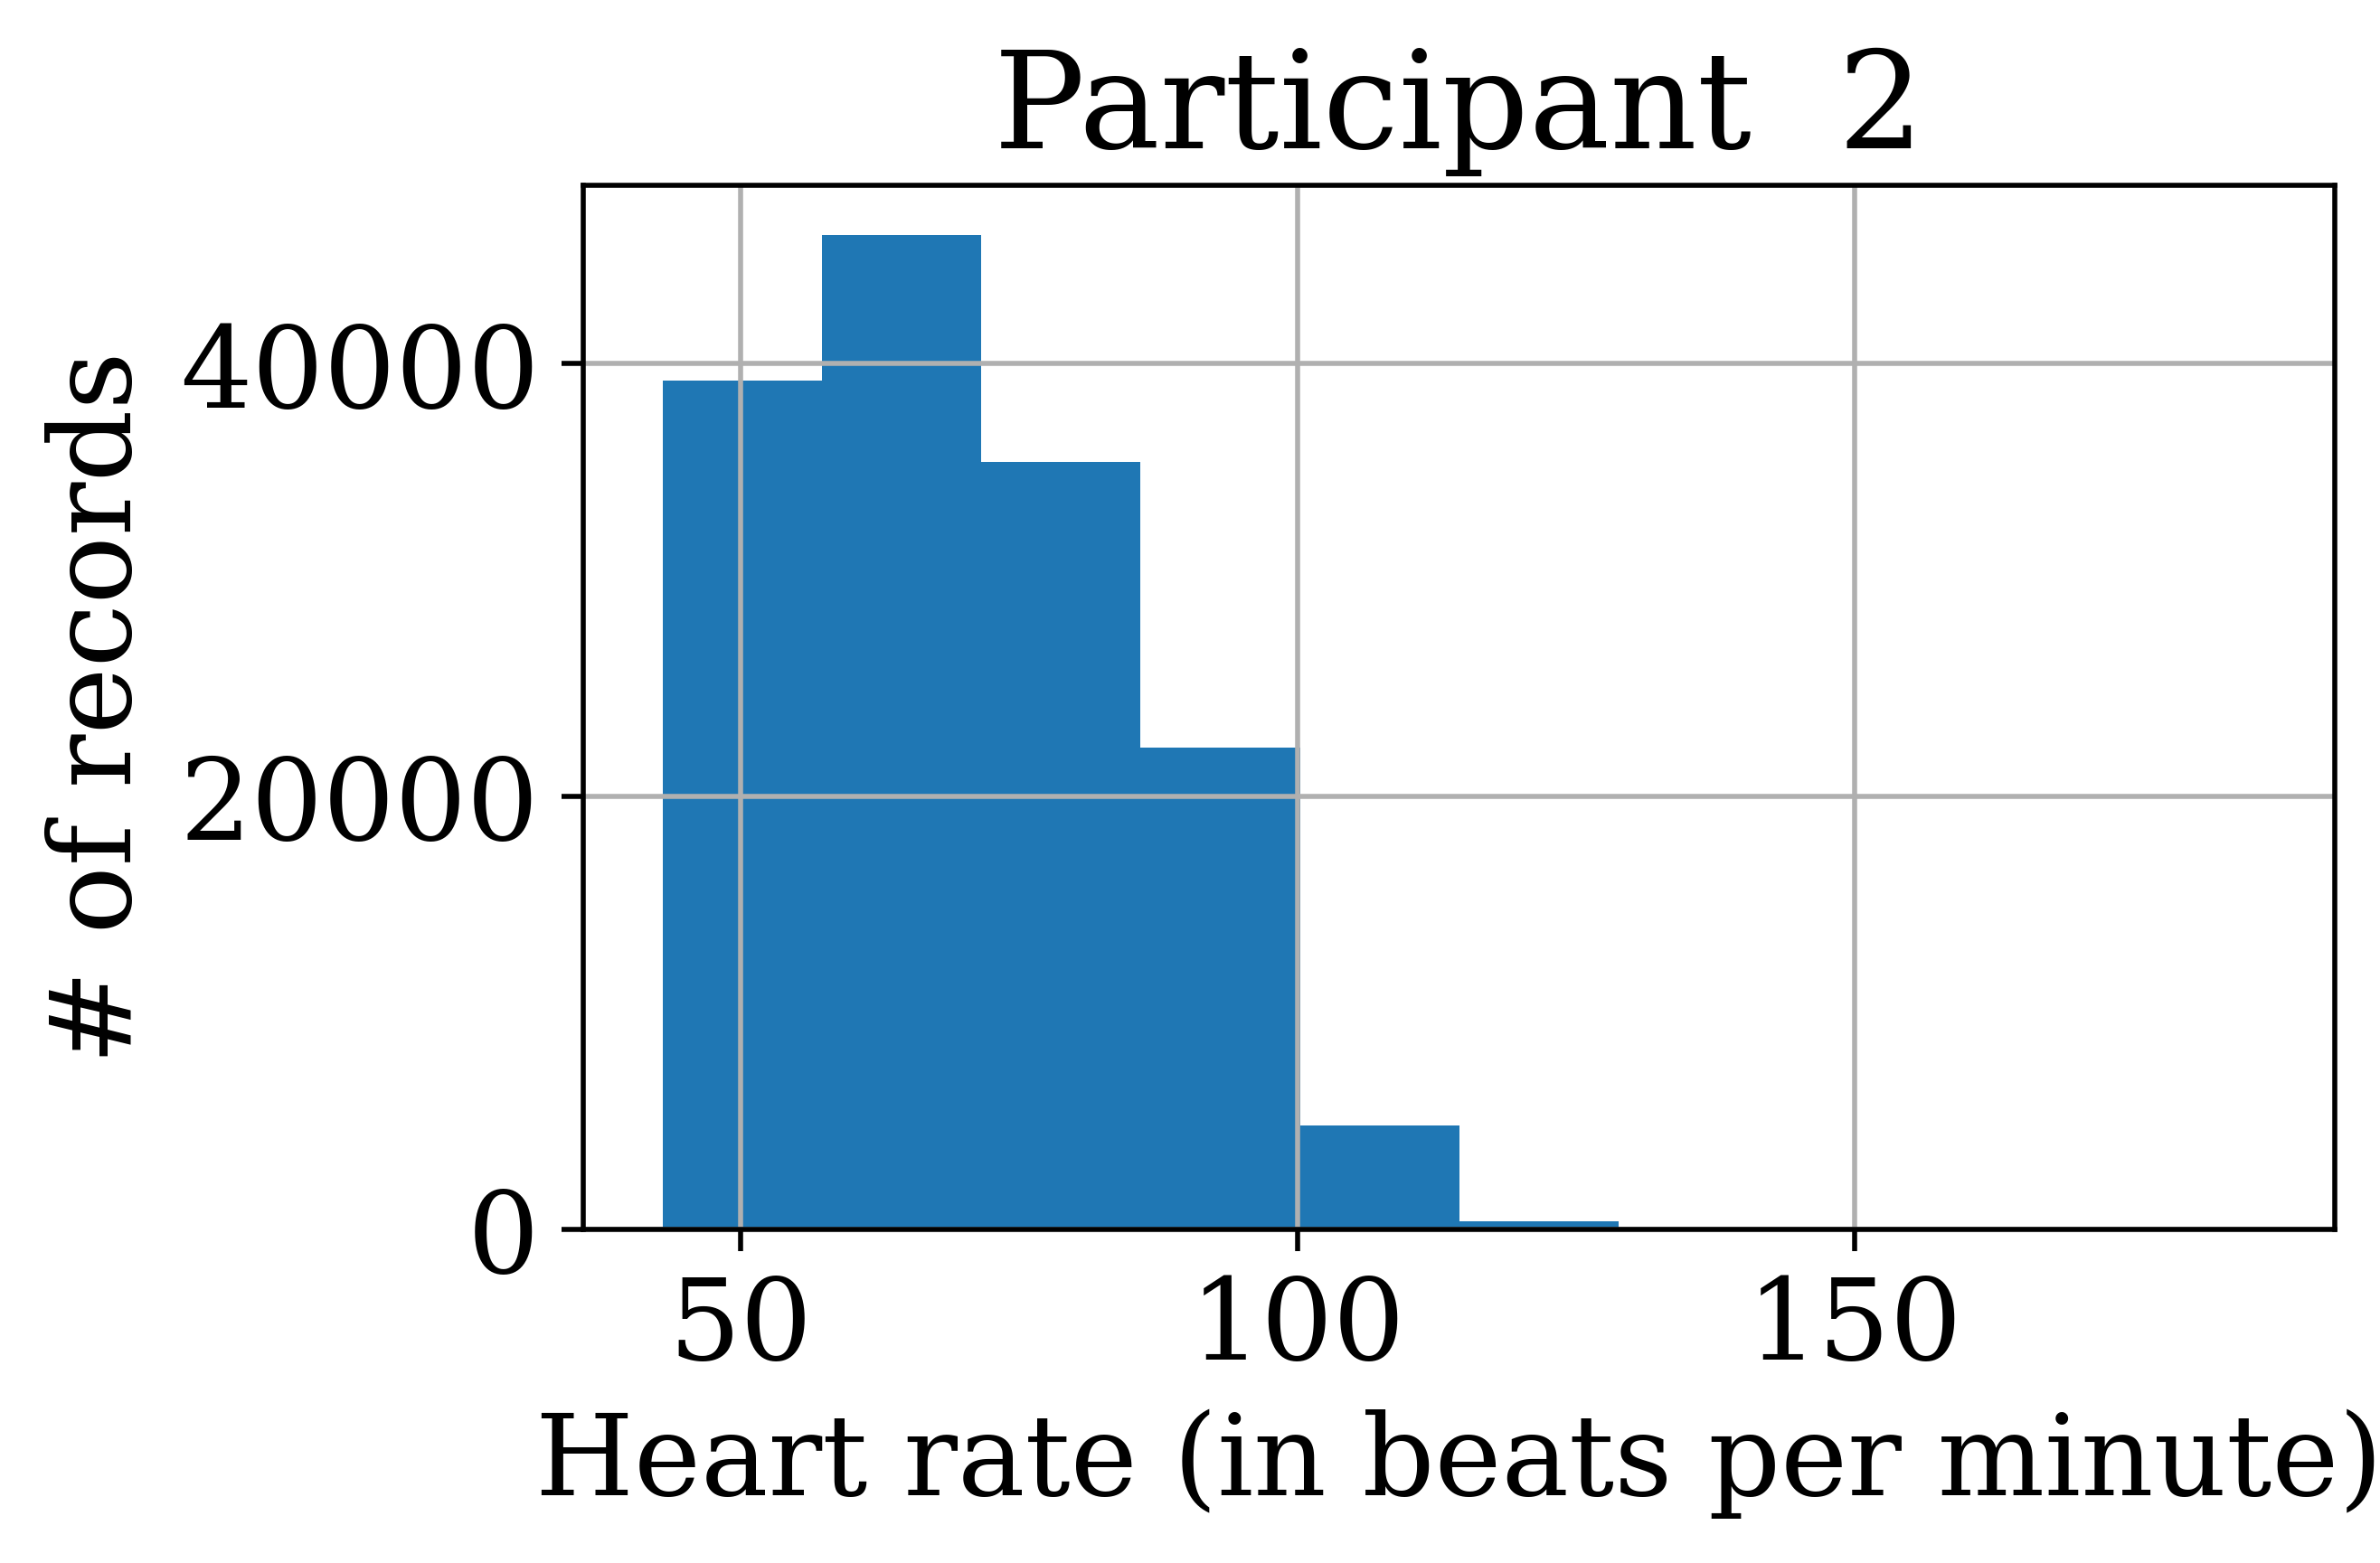

In [11]:
plt.rcParams['font.size'] = '18'
f = plt.figure(figsize=(5,3), dpi=500)
ax1 = heart_rate['heart_rate'].hist(
    figsize = (5,3)
)
ax1.set_ylabel(r'# of records')
ax1.set_title('Participant  2')
ax1.set_xlabel(r'Heart rate (in beats per minute)')
ax1.tick_params(labelrotation=0)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
# plt.savefig('./visualization/heart rate/heart rate1.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Steps

In [12]:
steps = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Steps', index_col='Timestamp',
                           engine='openpyxl')
steps.sort_values('Timestamp', inplace=True)
steps = steps.loc[start_date:end_date_plus_one].rename(
    columns={'Number of Steps': 'steps'}
)
display(steps.describe())
display(steps.head())
display(steps.tail())

,steps
count,2654.000000
mean,109.274680
std,195.429505
min,0.000000
25%,0.000000
50%,15.000000
75%,140.000000
max,1392.000000


,steps
Timestamp,
2021-02-23 00:00:00,17
2021-02-23 00:15:00,0
2021-02-23 00:30:00,0
2021-02-23 00:45:00,0
2021-02-23 01:00:00,0


,steps
Timestamp,
2021-03-24 22:45:00,0
2021-03-24 23:00:00,0
2021-03-24 23:15:00,0
2021-03-24 23:30:00,0
2021-03-24 23:45:00,0


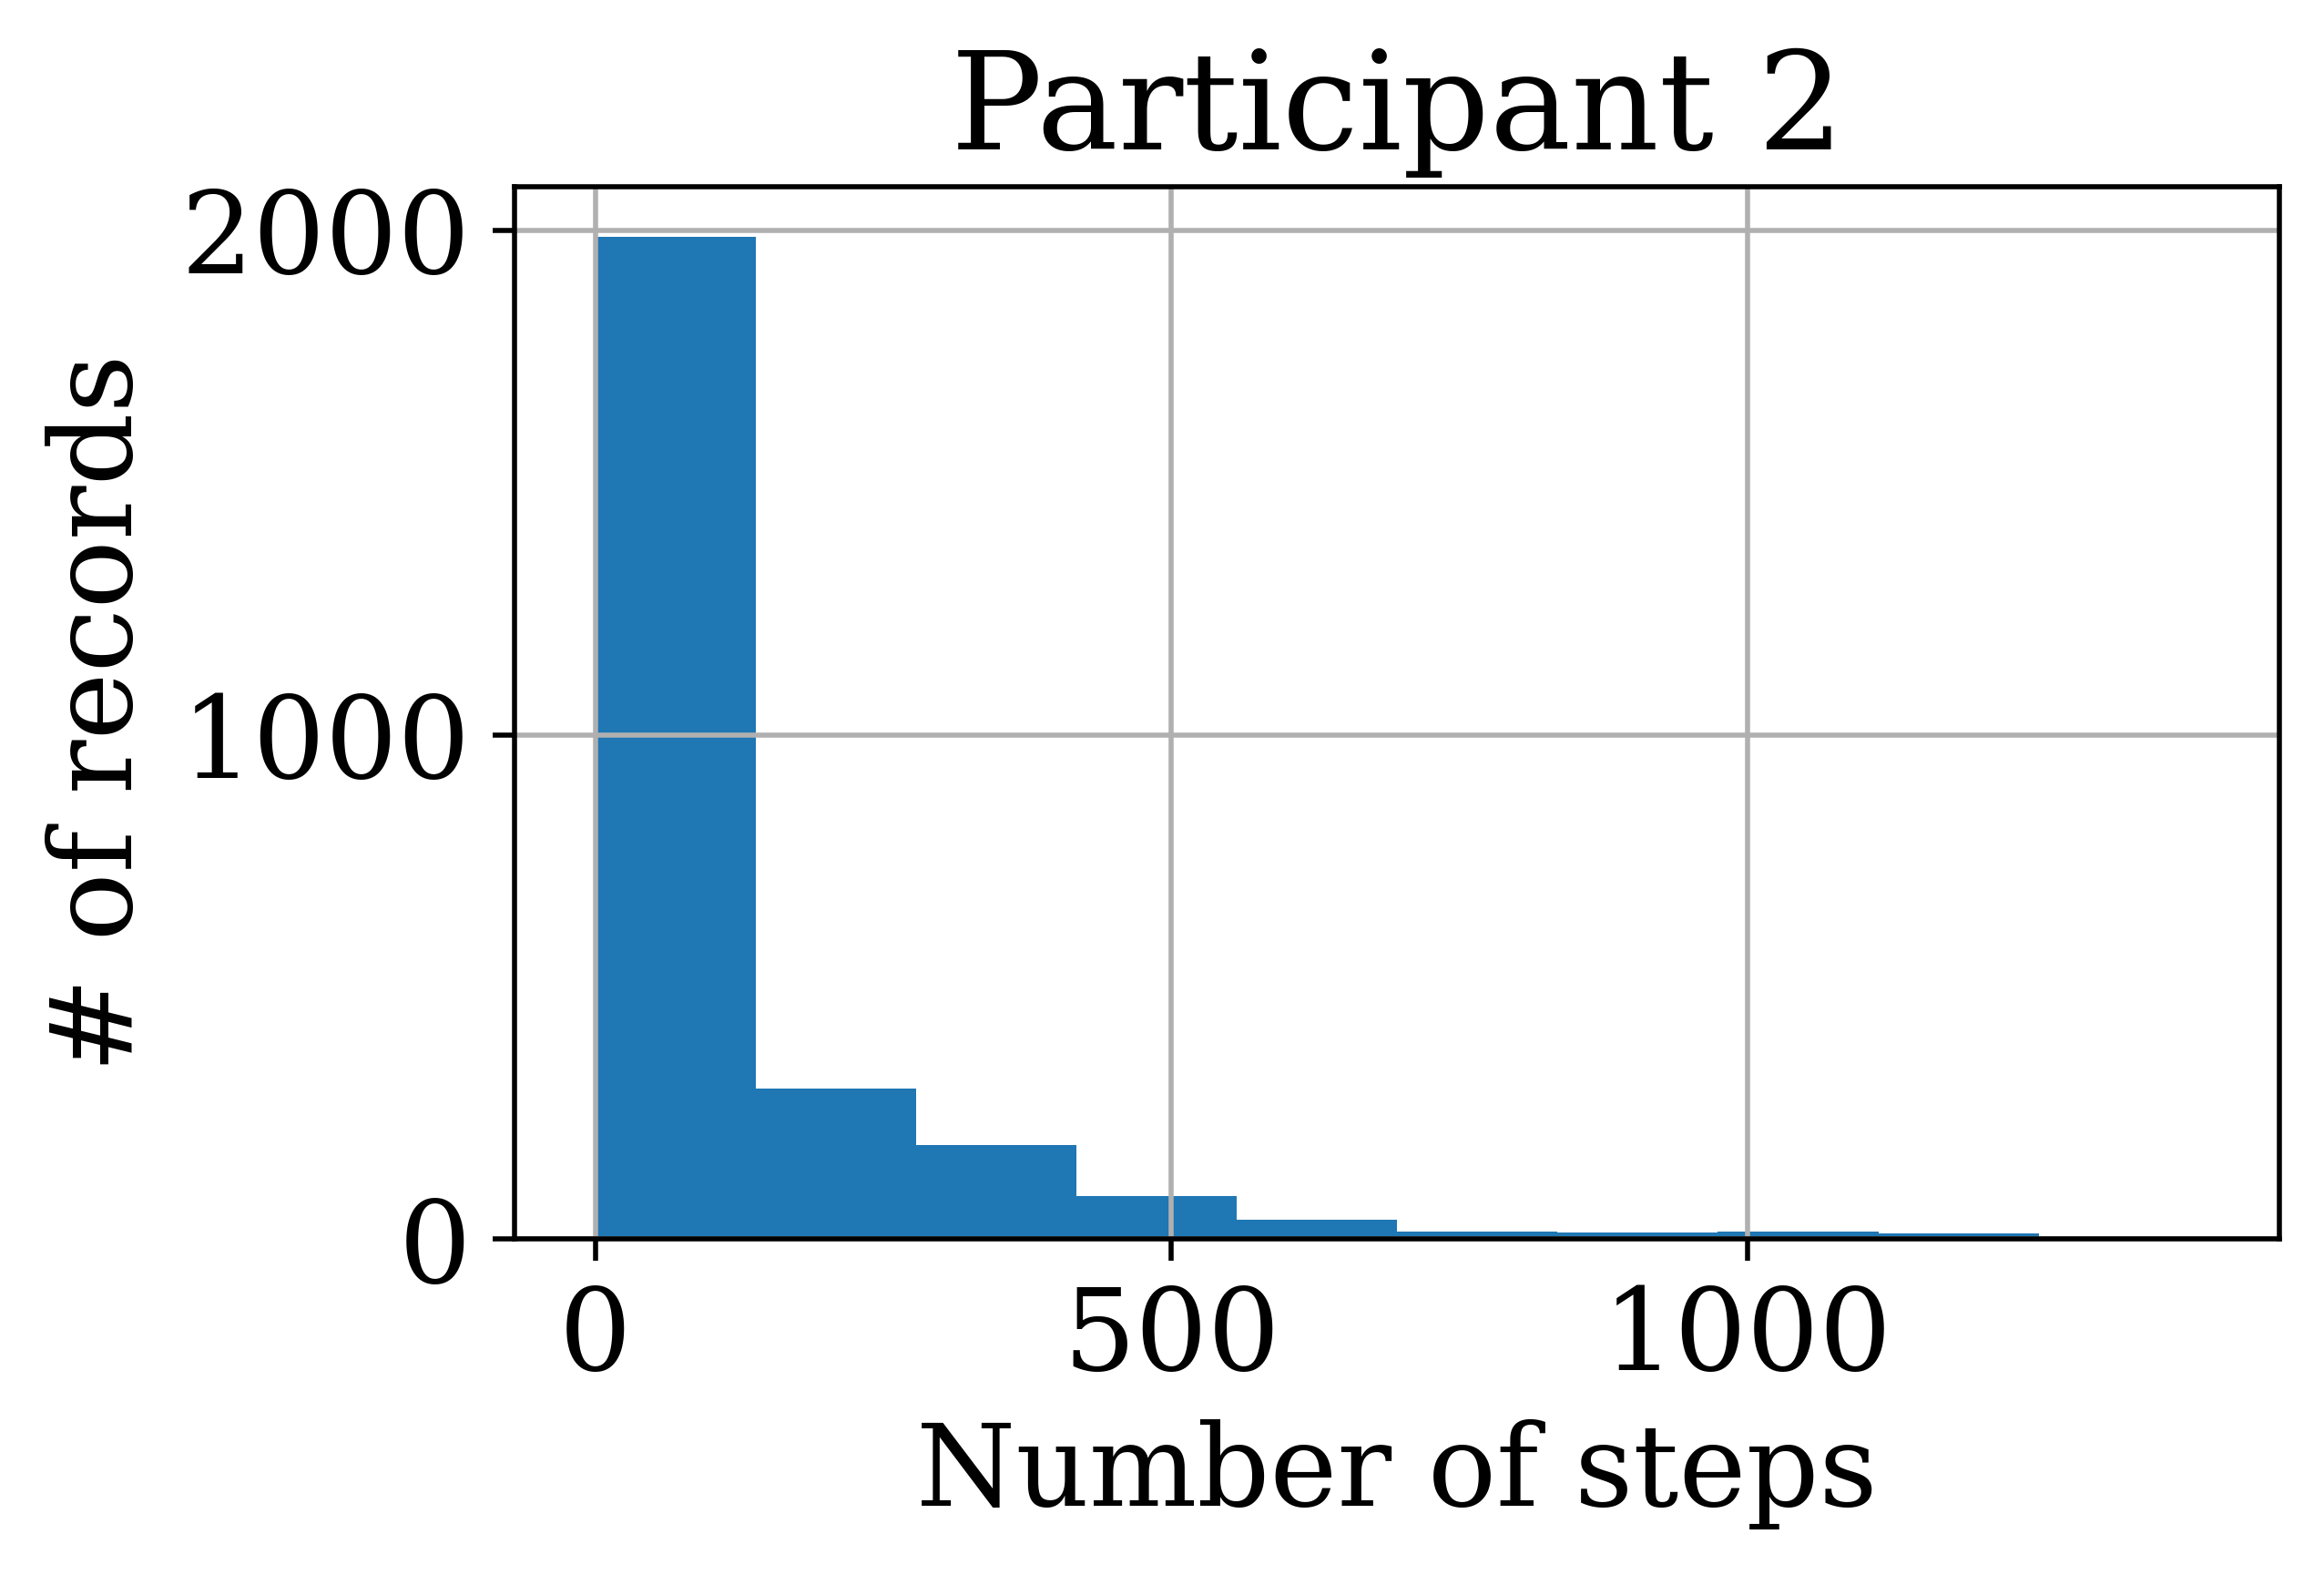

In [13]:
plt.rcParams['font.size'] = '18'
f = plt.figure(figsize=(5,3), dpi=500)
ax1 = steps['steps'].hist(
    figsize = (5,3)
)
ax1.set_ylabel(r'# of records')
ax1.set_title('Participant 2')
ax1.set_xlabel(r'Number of steps')
ax1.tick_params(labelrotation=0)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
# plt.savefig('./visualization/steps/steps1.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Stress

In [14]:
stress = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Stress', index_col='Timestamp',
                           engine='openpyxl')
stress.sort_values('Timestamp', inplace=True)
stress = stress.loc[start_date:end_date_plus_one].rename(
    columns={'Stress Score': 'stress_score', 'Stress Interpretation': 'stress_interpretation'}
)
display(stress.describe())
display(stress.head())
display(stress.tail())

,stress_score
count,13135.000000
mean,11.229768
std,20.751568
min,-2.000000
25%,-2.000000
50%,-1.000000
75%,16.000000
max,94.000000


,stress_score,stress_interpretation
Timestamp,,
2021-02-23 00:00:00,17,Rest
2021-02-23 00:03:00,13,Rest
2021-02-23 00:06:00,13,Rest
2021-02-23 00:09:00,14,Rest
2021-02-23 00:12:00,16,Rest


,stress_score,stress_interpretation
Timestamp,,
2021-03-24 23:45:00,-1,Not enough data
2021-03-24 23:48:00,-1,Not enough data
2021-03-24 23:51:00,-1,Not enough data
2021-03-24 23:54:00,-1,Not enough data
2021-03-24 23:57:00,-1,Not enough data


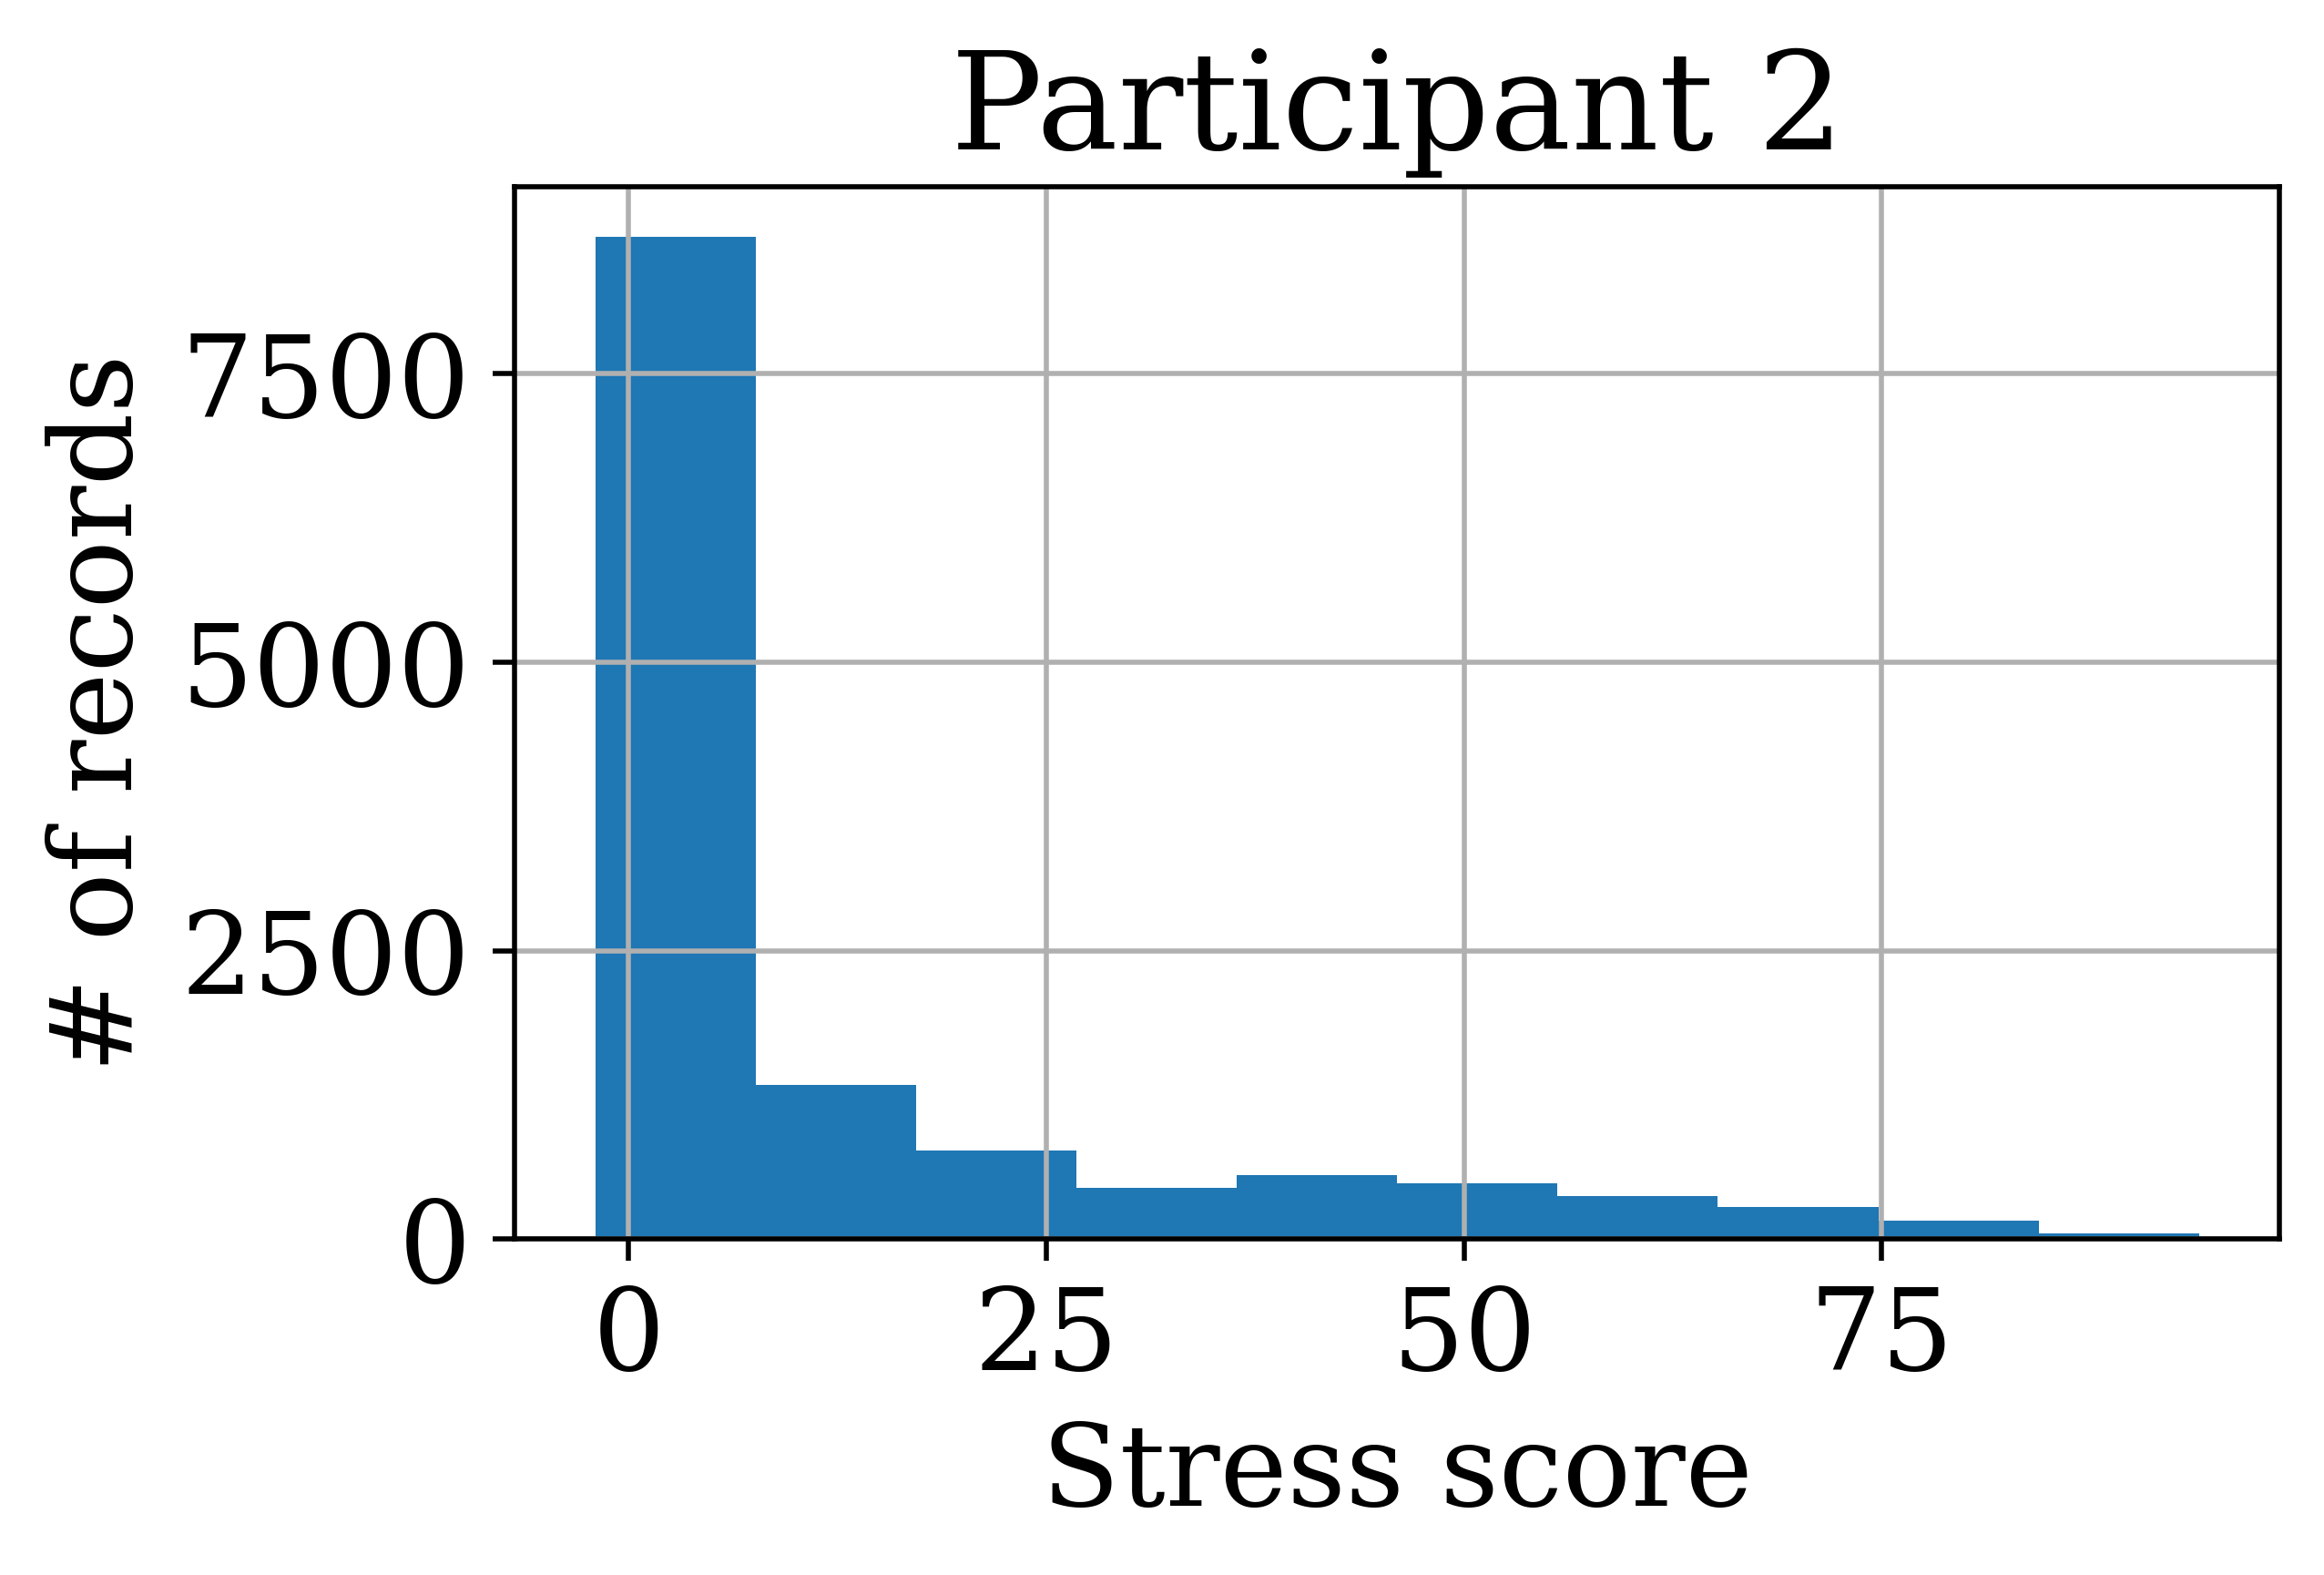

In [15]:
plt.rcParams['font.size'] = '18'
f = plt.figure(figsize=(5,3), dpi=500)
ax1 = stress['stress_score'].hist(
    figsize = (5,3)
)
ax1.set_ylabel(r'# of records')
ax1.set_title('Participant 2')
ax1.set_xlabel(r'Stress score')
ax1.tick_params(labelrotation=0)
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
# plt.savefig('./visualization/stress/stress1.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Sleep

In [16]:
sleep = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Sleep', index_col='Calendar Date',
                           engine='openpyxl')
sleep.sort_values('Start Time', inplace=True)
sleep = sleep.loc[start_date:end_date_plus_one]

# Compute duration in minutes
sleep['Duration'] = (sleep['End Time'] - sleep['Start Time']) / np.timedelta64(1, "m")

# Show original sleep data format
display('Original')
display(sleep.head())
display(sleep.tail())

# Transform sleep data by sleep classification type
sleep = sleep.pivot_table(
    index = 'Calendar Date',
    columns = 'Sleep Type',
    values = 'Duration',
    aggfunc = 'sum'
)
sleep = pd.DataFrame(sleep.to_records()).set_index('Calendar Date').fillna(0)
# Make sure that sleep index is a DateTimeIndex type
sleep.index = pd.to_datetime(sleep.index)
sleep.index.name = 'Timestamp'

# Compute total non-rem sleep
sleep['nonrem_total'] = (sleep['deep'] + sleep['light'])
sleep['total'] = (sleep['nonrem_total'] + sleep['rem'])
sleep['nonrem_percentage'] = sleep['nonrem_total'] / sleep['total']
sleep['sleep_efficiency'] = sleep['total'] / (sleep['total'] + sleep['awake'])

# Ignore unmeasurable column from sleep dataset
if 'unmeasurable' in sleep.columns:
    sleep.drop(columns=['unmeasurable'], inplace=True)

# # Show transformed sleep data
display('Summary')
display(sleep.describe())
display('Transformed')
display(sleep)

'Original'

,Start Time,End Time,Sleep Type,Duration
Calendar Date,,,,
2021-02-23,2021-02-23 00:06:00,2021-02-23 00:11:00,light,5.0
2021-02-23,2021-02-23 00:11:00,2021-02-23 00:12:00,awake,1.0
2021-02-23,2021-02-23 00:12:00,2021-02-23 02:35:00,light,143.0
2021-02-23,2021-02-23 02:35:00,2021-02-23 02:36:00,rem,1.0
2021-02-23,2021-02-23 02:36:00,2021-02-23 02:38:00,light,2.0


,Start Time,End Time,Sleep Type,Duration
Calendar Date,,,,
2021-03-24,2021-03-24 04:26:00,2021-03-24 04:27:00,rem,1.0
2021-03-24,2021-03-24 04:27:00,2021-03-24 04:32:00,light,5.0
2021-03-24,2021-03-24 04:32:00,2021-03-24 04:33:00,rem,1.0
2021-03-24,2021-03-24 04:33:00,2021-03-24 05:59:00,light,86.0
2021-03-24,2021-03-24 05:59:00,2021-03-24 06:01:00,rem,2.0


'Summary'

,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,4.760000,94.920000,124.680000,17.880000,219.600000,237.480000,0.929781,0.987451
std,15.653221,48.781759,66.432748,22.168521,60.117247,67.429667,0.073011,0.035657
min,0.000000,0.000000,31.000000,0.000000,138.000000,138.000000,0.772277,0.828442
25%,0.000000,67.000000,79.000000,1.000000,187.000000,191.000000,0.881279,0.994872
50%,0.000000,100.000000,116.000000,11.000000,207.000000,219.000000,0.949541,1.000000
75%,1.000000,144.000000,168.000000,26.000000,237.000000,266.000000,0.997126,1.000000
max,76.000000,161.000000,310.000000,92.000000,361.000000,404.000000,1.000000,1.000000


'Transformed'

,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
Timestamp,,,,,,,,
2021-02-23,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-25,0.0,150.0,66.0,54.0,216.0,270.0,0.800000,1.000000
2021-02-26,0.0,83.0,55.0,0.0,138.0,138.0,1.000000,1.000000
2021-02-27,0.0,116.0,96.0,5.0,212.0,217.0,0.976959,1.000000
2021-02-28,1.0,119.0,203.0,29.0,322.0,351.0,0.917379,0.997159
2021-03-02,0.0,78.0,127.0,14.0,205.0,219.0,0.936073,1.000000
2021-03-03,0.0,125.0,42.0,21.0,167.0,188.0,0.888298,1.000000
2021-03-04,76.0,144.0,217.0,6.0,361.0,367.0,0.983651,0.828442
2021-03-05,0.0,57.0,152.0,17.0,209.0,226.0,0.924779,1.000000


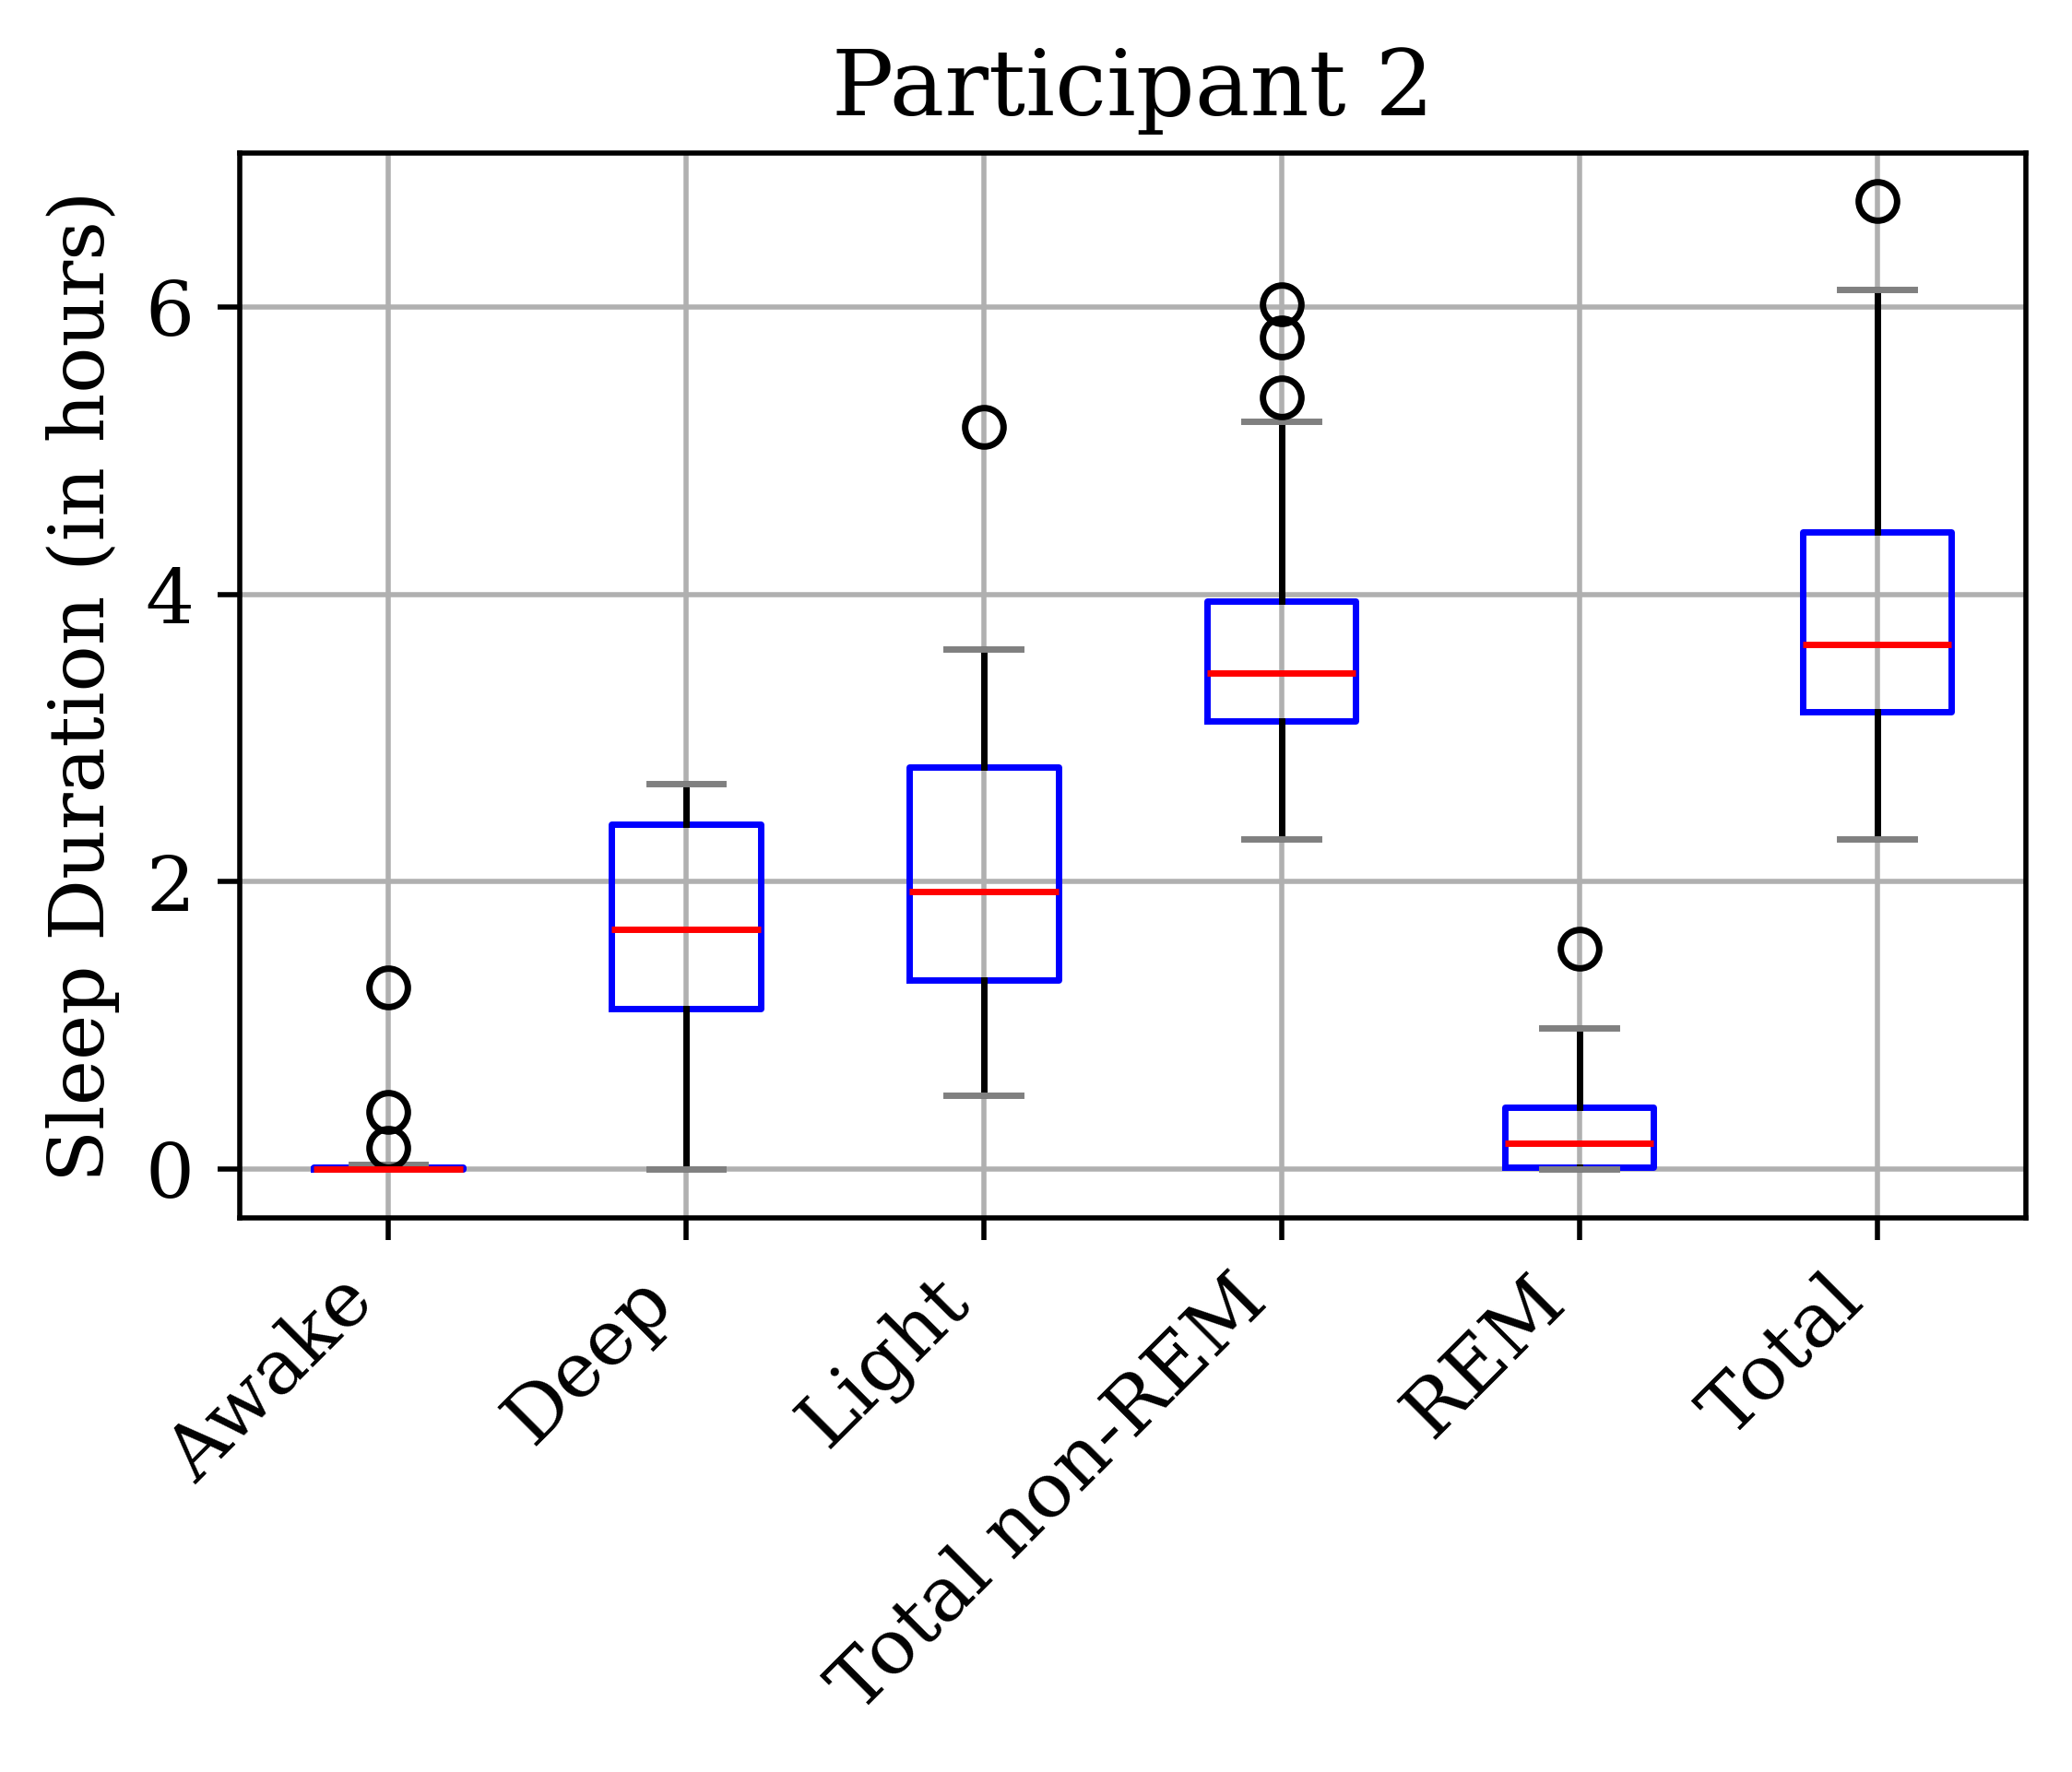

In [17]:
grouped_sleep = sleep.apply(lambda x: x / 60)

plt.rcParams['font.size'] = '12'
f = plt.figure(figsize=(5,3), dpi=500)
ax1 = grouped_sleep[['awake', 'deep', 'light', 'nonrem_total', 'rem', 'total']].boxplot(
    color = color,
    figsize = (5,3)
)
ax1.set_ylabel(r'Sleep Duration (in hours)')
ax1.set_title('Participant 2')
ax1.set_xticklabels(['Awake', 'Deep', 'Light', 'Total non-REM', 'REM', 'Total'], rotation=45, ha='right')
plt.suptitle('')
plt.rc('text') # , usetex=False)
plt.rc('font', family='serif')
# plt.savefig('./visualization/sleep/sleeplevel1.pdf', bbox_inches='tight', dpi=500)
plt.show()

## Complete collection period before resampling

First, fill missing values according to Garmin's documentation and within the collection period.

### Heart rate
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [18]:
heart_rate_freq = '15s'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = heart_rate_freq, name='Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)

heart_rate = reference.merge(
    heart_rate.resample(heart_rate_freq).mean(), on='Timestamp', how='left'
).fillna(-1)

display(heart_rate.describe())
display(heart_rate.head())
display(heart_rate.tail())

,heart_rate
count,172800.000000
mean,59.856956
std,28.830976
min,-1.000000
25%,52.000000
50%,64.000000
75%,79.000000
max,186.000000


,heart_rate
Timestamp,
2021-02-23 00:00:00,65.0
2021-02-23 00:00:15,68.0
2021-02-23 00:00:30,68.0
2021-02-23 00:00:45,68.0
2021-02-23 00:01:00,68.0


,heart_rate
Timestamp,
2021-03-24 23:58:45,-1.0
2021-03-24 23:59:00,-1.0
2021-03-24 23:59:15,-1.0
2021-03-24 23:59:30,-1.0
2021-03-24 23:59:45,-1.0


### Steps
* Fill missing values with -1 to standardize with other Garmin datasets
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [19]:
# Steps
#     fill missing values with -1 to standardize with other Garmin dataset
#     missing values for the expected period indicates Garmin vivosmart4 was not worn
steps_freq = '15min'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = steps_freq, name='Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)

steps = reference.merge(
    steps.resample(steps_freq).mean(), on='Timestamp', how='left'
).fillna(-1)

display(steps.describe())
display(steps.head())
display(steps.tail())

,steps
count,2880.000000
mean,100.621181
std,189.932276
min,-1.000000
25%,0.000000
50%,8.000000
75%,122.250000
max,1392.000000


,steps
Timestamp,
2021-02-23 00:00:00,17.0
2021-02-23 00:15:00,0.0
2021-02-23 00:30:00,0.0
2021-02-23 00:45:00,0.0
2021-02-23 01:00:00,0.0


,steps
Timestamp,
2021-03-24 22:45:00,0.0
2021-03-24 23:00:00,0.0
2021-03-24 23:15:00,0.0
2021-03-24 23:30:00,0.0
2021-03-24 23:45:00,0.0


### Stress
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [20]:
# Step 1: Create a uniform timestamp reference
stress_freq = '3min'
reference = pd.DataFrame(
    index=pd.date_range(
        start=start_date, end=end_date_plus_two,
        freq=stress_freq, name='Timestamp'
    ).drop(pd.Timestamp(end_date_plus_two))
)

# Step 2: Resample only numeric columns of `stress`
stress_numeric = stress.select_dtypes(include='number')
stress_resampled = stress_numeric.resample(stress_freq).mean()

# Step 3: Merge resampled stress with the reference timestamp
stress = reference.merge(stress_resampled, on='Timestamp', how='left').fillna(-1)

# Step 4: Display
display(stress.describe())
display(stress.head())
display(stress.tail())


,stress_score
count,14400.000000
mean,10.155417
std,20.119174
min,-2.000000
25%,-1.000000
50%,-1.000000
75%,15.000000
max,94.000000


,stress_score
Timestamp,
2021-02-23 00:00:00,17.0
2021-02-23 00:03:00,13.0
2021-02-23 00:06:00,13.0
2021-02-23 00:09:00,14.0
2021-02-23 00:12:00,16.0


,stress_score
Timestamp,
2021-03-24 23:45:00,-1.0
2021-03-24 23:48:00,-1.0
2021-03-24 23:51:00,-1.0
2021-03-24 23:54:00,-1.0
2021-03-24 23:57:00,-1.0


### Sleep
* Fill missing values with -1 to standardize with other Garmin datasets
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [21]:
sleep_freq = 'D'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = sleep_freq, name = 'Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)
sleep = reference.merge(
    sleep.resample(sleep_freq).mean(), on="Timestamp", how='left'
).fillna(-1)

# Show transformed sleep data
display('Summary')
display(sleep.describe())
display('Transformed')
display(sleep)


'Summary'

,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3.800000,78.933333,103.733333,14.733333,182.833333,197.733333,0.608151,0.656209
std,14.406416,57.369903,76.953606,21.399216,99.914820,109.243775,0.734491,0.754039
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,18.500000,44.750000,0.000000,154.250000,176.250000,0.811864,0.967731
50%,0.000000,83.500000,101.500000,6.500000,200.000000,212.000000,0.928925,0.996755
75%,1.000000,123.500000,151.500000,21.000000,219.000000,259.250000,0.982908,1.000000
max,76.000000,161.000000,310.000000,92.000000,361.000000,404.000000,1.000000,1.000000


'Transformed'

,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
Timestamp,,,,,,,,
2021-02-23,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-24,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000
2021-02-25,0.0,150.0,66.0,54.0,216.0,270.0,0.800000,1.000000
2021-02-26,0.0,83.0,55.0,0.0,138.0,138.0,1.000000,1.000000
2021-02-27,0.0,116.0,96.0,5.0,212.0,217.0,0.976959,1.000000
2021-02-28,1.0,119.0,203.0,29.0,322.0,351.0,0.917379,0.997159
2021-03-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000
2021-03-02,0.0,78.0,127.0,14.0,205.0,219.0,0.936073,1.000000
2021-03-03,0.0,125.0,42.0,21.0,167.0,188.0,0.888298,1.000000


## Combine Garmin Dataset
Resample according to resampling plan.

Missing values due to resampling:
* Fill using previous known value.
* ``ffill()`` does this step.

In [22]:
# Create reference timestamp dataframe for the collection period
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = target_freq, name = 'Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)
display('Reference timestamp')
display(reference)

# Combine each Garmin dataset to reference timestamp dataframe
display('Combined Data')
garmin_data = reference.merge(
    # downsample heart rate from 15sec to 1min
    #   missing values = -1 same treatment with Garmin with regards to missing value, fitness tracker not worn
    heart_rate.resample(target_freq).mean(), on='Timestamp', how='left'
).ffill()
garmin_data = garmin_data.merge(
    steps.resample(target_freq).mean(), on='Timestamp', how='left'
).ffill()
garmin_data = garmin_data.merge(
    stress.resample(target_freq).mean(), on='Timestamp', how='left'
).ffill()
garmin_data = garmin_data.merge(
    sleep.resample(target_freq).mean(), on='Timestamp', how='left'
).ffill()
display(garmin_data)

'Reference timestamp'

""
Timestamp
2021-02-23 00:00:00
2021-02-23 00:00:15
2021-02-23 00:00:30
2021-02-23 00:00:45
2021-02-23 00:01:00
...
2021-03-24 23:58:45
2021-03-24 23:59:00
2021-03-24 23:59:15


'Combined Data'

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
Timestamp,,,,,,,,,,,
2021-02-23 00:00:00,65.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-23 00:00:15,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-23 00:00:30,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-23 00:00:45,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
2021-02-23 00:01:00,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-24 23:58:45,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000
2021-03-24 23:59:00,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000
2021-03-24 23:59:15,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000


# Combine FonLog Dataset and Garmin Dataset

Match wearing-off to combined Garmin data based on wearing-off start and end

In [23]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select 
        garmin_data.*,
        wearing_off_periods.[activity_target.activity_id] as 'wearing_off_id',
        wearing_off_periods.[started_at] as 'wearing_off_start',
        wearing_off_periods.[finished_at] as 'wearing_off_end',
        case
            when wearing_off_periods.[started_at] is not null THEN 1
        else 0
        end as 'wearing_off'
    from garmin_data
    left join wearing_off_periods
    on garmin_data.[Timestamp] BETWEEN wearing_off_periods.[started_at] AND wearing_off_periods.[finished_at]
'''

# Change timestamp to lowercase
combined_data = pysqldf(cond_join).rename(columns={
    "Timestamp": "timestamp"
})

# Drop duplicates based on timestamp
combined_data = combined_data.drop_duplicates(subset=['timestamp'])

# Set timestamp as index
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data = combined_data.set_index('timestamp')
print(combined_data.columns)

Index(['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 'light', 'rem',
       'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
       'wearing_off_id', 'wearing_off_start', 'wearing_off_end',
       'wearing_off'],
      dtype='object')


Match drug intake to combined Garmin data based on drug intake start and end

In [24]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select 
        combined_data.*,
        drug_intake.[started_at] as 'drug_intake_start'
    from combined_data
    left join drug_intake
    on combined_data.[timestamp] BETWEEN drug_intake.[started_at] AND drug_intake.[finished_at]
'''
combined_data = pysqldf(cond_join).drop_duplicates(subset=['timestamp'])

# Set timestamp as index
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data = combined_data.set_index('timestamp')
print(combined_data.columns)

Index(['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 'light', 'rem',
       'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
       'wearing_off_id', 'wearing_off_start', 'wearing_off_end', 'wearing_off',
       'drug_intake_start'],
      dtype='object')


In [25]:
# Drop the duplicate 'drug_intake_start' column
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]


Compute time from last drug taken
* find the difference between the reference timestamp and the drug intake start
* convert difference to target frequency's unit e.g. minute, seconds

In [26]:
combined_data['time_from_last_drug_taken'] = ''
combined_data['time_from_last_drug_taken'] = (
    pd.to_datetime(combined_data.index) - pd.to_datetime(combined_data['drug_intake_start'])
) / np.timedelta64(1, target_freq_unit2)
combined_data.drop(columns=['drug_intake_start'], inplace=True)

Fill records after a drug intake report by adding target frequency value
* add 1 minute, 15 seconds or 15 minutes to succeeding records after the drug intake end
* reference: https://stackoverflow.com/a/42748625/2303766

In [27]:
gid = combined_data['time_from_last_drug_taken'].notnull().cumsum()
dg = combined_data.groupby(gid)
base = dg['time_from_last_drug_taken'].transform('last')
combined_data['time_from_last_drug_taken'] = (  base + ( dg.cumcount() ) * target_freq_as_int)

if combined_data['time_from_last_drug_taken'].isna().any():
    combined_data['time_from_last_drug_taken'] = combined_data['time_from_last_drug_taken'].fillna(0)

In [28]:
if (target_freq == '1min'):
    # For 1min, view transition
    display('1min - Transition from drug intake record to no drug intake record')
    display(combined_data.iloc[143:147, 15:20])
    display('Transition from no drug intake record to drug intake record')
    display(combined_data.iloc[405:409, 15:20])
elif (target_freq == '15min'):
    # For 15min, view transition
    display('15min - Transition from drug intake record to no drug intake record')
    display(combined_data.iloc[8:12, 15:20])
    display('Transition from no drug intake record to drug intake record')
    display(combined_data.iloc[26:30, 15:20])
elif (target_freq == '15s'):
    # For 15sec, view transition
    display('15sec - Transition from drug intake record to no drug intake record')
    display(combined_data.iloc[575:579, 15:20])
    display('Transition from no drug intake record to drug intake record')
    display(combined_data.iloc[1626:1630, 15:20])

'15sec - Transition from drug intake record to no drug intake record'

,time_from_last_drug_taken
timestamp,
2021-02-23 02:23:45,0.0
2021-02-23 02:24:00,0.0
2021-02-23 02:24:15,0.0
2021-02-23 02:24:30,0.0


'Transition from no drug intake record to drug intake record'

,time_from_last_drug_taken
timestamp,
2021-02-23 06:46:30,0.0
2021-02-23 06:46:45,0.0
2021-02-23 06:47:00,0.0
2021-02-23 06:47:15,0.0


# View Combined Dataset

Display combined dataset

In [29]:
display(combined_data)

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,wearing_off_id,wearing_off_start,wearing_off_end,wearing_off,time_from_last_drug_taken
timestamp,,,,,,,,,,,,,,,,
2021-02-23 00:00:00,65.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827,NaN,None,None,0,0.0
2021-02-23 00:00:15,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827,NaN,None,None,0,0.0
2021-02-23 00:00:30,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827,NaN,None,None,0,0.0
2021-02-23 00:00:45,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827,NaN,None,None,0,0.0
2021-02-23 00:01:00,68.0,17.0,17.0,2.0,0.0,150.0,27.0,150.0,177.0,0.847458,0.988827,NaN,None,None,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-24 23:58:45,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000,NaN,None,None,0,400725.0
2021-03-24 23:59:00,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000,NaN,None,None,0,400740.0
2021-03-24 23:59:15,-1.0,0.0,-1.0,0.0,35.0,168.0,4.0,203.0,207.0,0.980676,1.000000,NaN,None,None,0,400755.0


In [30]:
display(combined_data.iloc[:,0:3].describe())
display(combined_data.iloc[:,3:11].describe())
display(combined_data.iloc[:,14:16].describe())

,heart_rate,steps,stress_score
count,172800.000000,172800.000000,172800.000000
mean,59.856956,100.621181,10.155417
std,28.830976,189.899848,20.118534
min,-1.000000,-1.000000,-2.000000
25%,52.000000,0.000000,-1.000000
50%,64.000000,8.000000,-1.000000
75%,79.000000,122.250000,15.000000
max,186.000000,1392.000000,94.000000


,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency
count,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000
mean,3.800000,78.933333,103.733333,14.733333,182.833333,197.733333,0.608151,0.656209
std,14.164315,56.405797,75.660395,21.039600,98.235744,107.407925,0.722148,0.741368
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,13.000000,44.000000,0.000000,150.000000,176.000000,0.800000,0.960699
50%,0.000000,83.500000,101.500000,6.500000,200.000000,212.000000,0.928925,0.996755
75%,1.000000,125.000000,152.000000,21.000000,220.000000,261.000000,0.983651,1.000000
max,76.000000,161.000000,310.000000,92.000000,361.000000,404.000000,1.000000,1.000000


,wearing_off,time_from_last_drug_taken
count,172800.000000,172800.000000
mean,0.025990,217421.020486
std,0.159105,251384.601000
min,0.000000,0.000000
25%,0.000000,7440.000000
50%,0.000000,129697.500000
75%,0.000000,333288.750000
max,1.000000,913785.000000


Check columns for any missing values except for ids, start & end columns

In [31]:
combined_data.isna().any()

heart_rate                   False
steps                        False
stress_score                 False
awake                        False
deep                         False
light                        False
rem                          False
nonrem_total                 False
total                        False
nonrem_percentage            False
sleep_efficiency             False
wearing_off_id                True
wearing_off_start             True
wearing_off_end               True
wearing_off                  False
time_from_last_drug_taken    False
dtype: bool

In [32]:
combined_data.to_excel(f'./data/combined_data/combined_data_{user}_{target_freq}.xlsx')

Check wearing-off by day

In [33]:
combined_data.groupby([combined_data.index.date]).sum()['wearing_off']

2021-02-23       0
2021-02-24       0
2021-02-25       0
2021-02-26       0
2021-02-27     626
2021-02-28    1368
2021-03-01     127
2021-03-02    1348
2021-03-03     101
2021-03-04       0
2021-03-05       0
2021-03-06     324
2021-03-07       0
2021-03-08       0
2021-03-09       0
2021-03-10       0
2021-03-11       0
2021-03-12       0
2021-03-13       0
2021-03-14       0
2021-03-15       0
2021-03-16       0
2021-03-17     164
2021-03-18       0
2021-03-19       0
2021-03-20     433
2021-03-21       0
2021-03-22       0
2021-03-23       0
2021-03-24       0
Name: wearing_off, dtype: int64